# MD vs MC for LJ bulk at  cutoff $r_c = 4\sigma$

We have from `DL_MONTE` coexistence at cutoff $r_c =4\sigma$ and $T= 1.1476$ at $P=0.064068$ and density $\rho=0.589$, in reduced units.

I test in lammps if these values can be reproduced.

I use `lj/cut` for the interaction potential. I do not shift it (i.e. the energies reflect this).


## NVT run at $\rho=0.589$

I first test directly in $NVT$ if the pressure that I get at the conditions above  matches `DL_MONTE`.

**It does  not**.

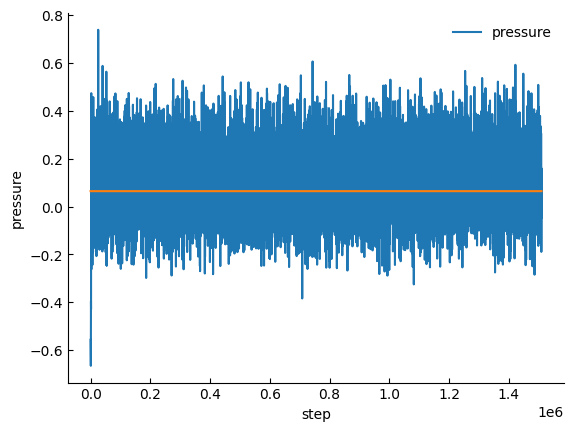

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


targetP = 0.064068

df = pd.read_csv("output-nvt-T1.1476-rho0.589.csv")

df.plot('step','pressure',xlabel='step',ylabel='pressure')
plt.plot(df['step'], np.ones_like(df['step'])*targetP)

The average pressure is slighlty above the target. Skipping early data, we can provide an estimate.

The MD pressure at density 0.589 is 0.10791764430753709


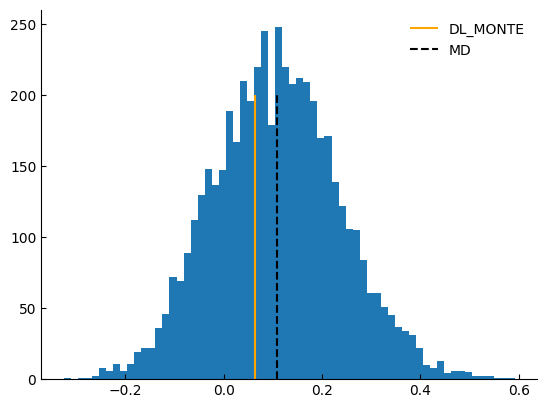

In [3]:
df['pressure'][10000:].hist(bins=64,grid=False)
plt.vlines(targetP,0,200, color='orange', label="DL_MONTE")
plt.vlines(df['pressure'][10000:].mean(),0,200, color='black', label="MD", linestyle="--")
plt.legend()
mdPressure = df['pressure'][10000:].mean()
print("The MD pressure at density 0.589 is",mdPressure)

## NPT run

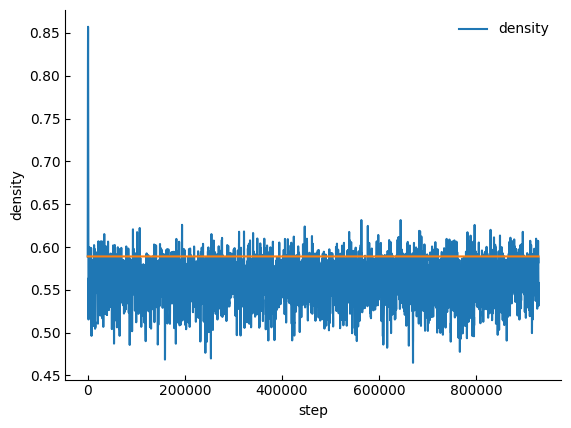

In [4]:
df_npt = pd.read_csv("output-npt-T1.1476-P0.064068.csv")
df_npt.plot('step','density', xlabel='step',ylabel='density',)
targetRho = 0.589
plt.plot(df_npt['step'], np.ones_like(df_npt['step'])*targetRho)

In [5]:
df_npt['density'][1000:].mean()

0.559614172755441

It seems that a slightly higher pressure is needed to get to the target density. The MD run, however, does not phase separate, so the liquid is still stable.

The disaggreement remains if I take larger simulations (1987 particles vs 589 for the plots above).

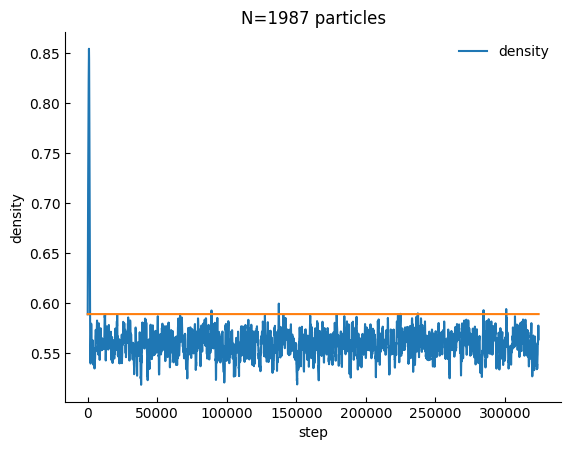

In [6]:
df_npt = pd.read_csv("output-npt-larger-T1.1476-P0.064068.csv")
df_npt.plot('step','density', xlabel='step',ylabel='density', title="N=1987 particles")
targetRho = 0.589
plt.plot(df_npt['step'], np.ones_like(df_npt['step'])*targetRho)


Convergence of the pressure is good.

0.06470932396987708

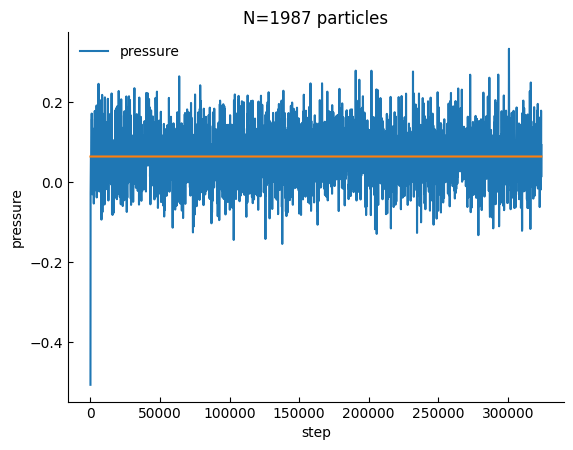

In [7]:
df_npt = pd.read_csv("output-npt-larger-T1.1476-P0.064068.csv")
df_npt.plot('step','pressure', xlabel='step',ylabel='pressure', title="N=1987 particles")
plt.plot(df_npt['step'], np.ones_like(df_npt['step'])*targetP)
df_npt.loc[500:,'pressure'].mean()

## Changing slighlty the cutoff for a smooth option

I can use for example a force smoothing potential with `lj/smooth/linear` with a much larger cutoff (found via optimising the second virial coefficient , see below.)

0.5954408791515333
30000


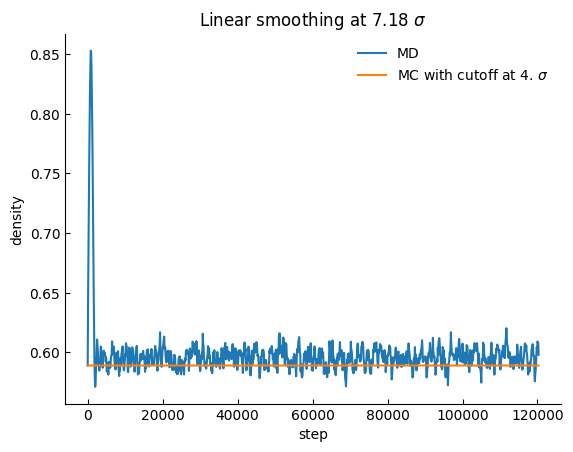

In [86]:
df_npt = pd.read_csv("output-npt-smooth-linear-T1.1476-P0.064068.csv")
df_npt.plot('step','density', xlabel='step',ylabel='density', title=r"Linear smoothing at 7.18 $\sigma$",label="MD")
targetRho = 0.589
plt.plot(df_npt['step'], np.ones_like(df_npt['step'])*targetRho, label= 'MC with cutoff at 4. $\sigma$')
print(df_npt['density'][300:].mean())
# plt.vlines(df_npt['step'])
plt.legend()
print(df_npt['step'][300])

print(df_npt['density'][300:].mean())

0.06612356230036431


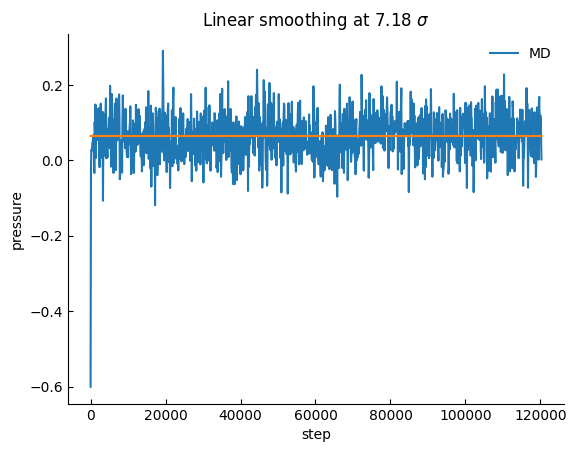

In [18]:

df_npt.plot('step','pressure', xlabel='step',ylabel='pressure', title=r"Linear smoothing at 7.18 $\sigma$",label="MD")
print(df_npt['pressure'][300:].mean())
plt.plot(df_npt['step'], np.ones_like(df_npt['step'])*targetP,)


What does this linear shifted potential look like?

(-0.5, 0.1)

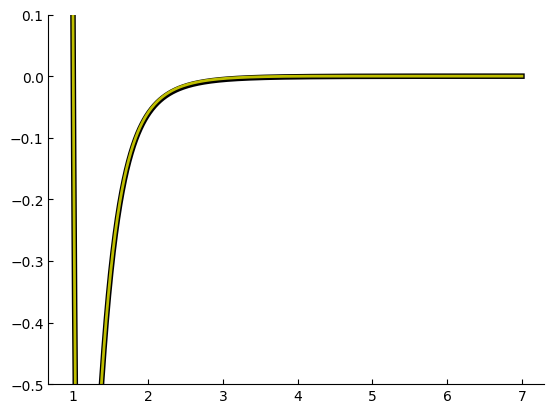

In [19]:
def lj(r,eps=1.,sig=1.):
    return 4*eps*((sig/r)**12-(sig/r)**6)
def ljforce(r,eps=1.,sig=1.):
    return -24/r*eps*( (sig/r)**6-2*(sig/r)**12)

def lj_smooth_linear(r,rc):
    # force at rc
    force = ljforce(rc)
    inner = r<rc
    E = np.zeros_like(r)
    rr = r[inner]
    E[inner] =  lj(rr)-lj(rc)+(rr-rc)*force
    return E


x = np.linspace(0.97,7,1000)

plt.plot(x,lj(x),'k', lw=4)
plt.plot(x,lj_smooth_linear(x,4.5), lw=2, color='y')
plt.ylim(-0.5,0.1)

In [146]:
from scipy.optimize import minimize_scalar
from scipy.integrate import simps
import scipy.integrate as integrate

x = np.linspace(0.0001,8,1000000)
T = 1.1476
beta=1./T

def lj_truncated(rc):
    inner = x<rc
    E = np.zeros_like(x)
    E[inner] = lj(x[inner])-lj(rc)
    return E

def lj_md(rc):
    return lj_smooth_linear(x,rc)

def b2(xc,u):
    return -2*np.pi*np.trapz(np.exp(-beta*u(xc))-1,x)

def objective(rc,md_pot=lj_md):
    # comparing against the MC truncated pootential at rc=4 sigma
    return (b2(rc,md_pot)-b2(4.0, lj_truncated))**2


res = minimize_scalar(objective,bounds=[2,10])
res.x

5.060130338662814

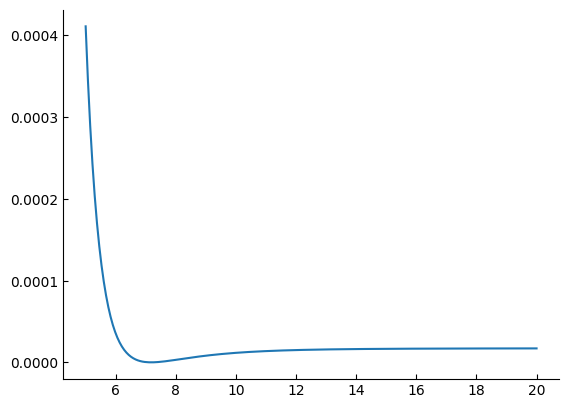

In [12]:
rcs = np.linspace(5,20,200)
v_objective = np.vectorize(objective)
plt.plot(rcs,v_objective(rcs))
# plt.ylim(0,0.01)

In [13]:
df_npt['step'][100]

10000

0.569015991527809
0.5689601194518542 0.0002862182075983845 0.588 -0.03238074923154041 5191


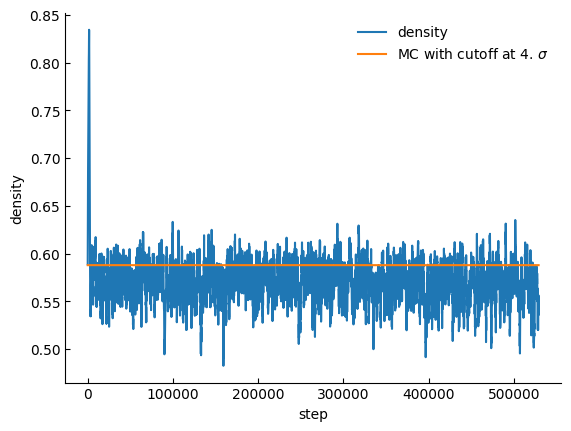

<Figure size 640x480 with 0 Axes>

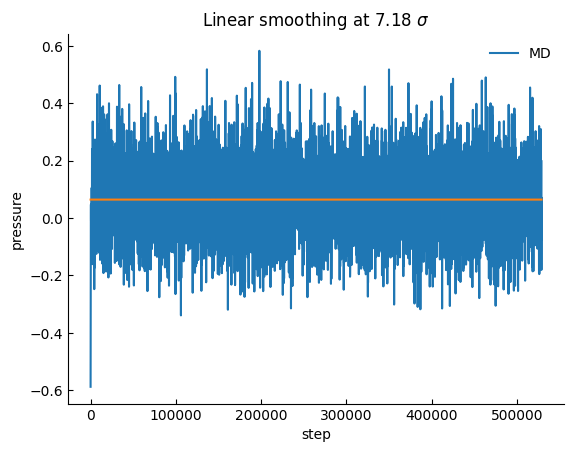

In [169]:
df_npt = pd.read_csv("output-npt-cut-shift-T1.1476-P0.064068.csv")
df_npt.plot('step','density', xlabel='step',ylabel='density', )
targetRho = 0.588
plt.plot(df_npt['step'], np.ones_like(df_npt['step'])*targetRho, label= 'MC with cutoff at 4. $\sigma$')
print(df_npt['density'][600:].mean())
# plt.vlines(df_npt['step'])
plt.legend()

plt.figure()
df_npt.plot('step','pressure', xlabel='step',ylabel='pressure', title=r"Linear smoothing at 7.18 $\sigma$",label="MD")
plt.plot(df_npt['step'], np.ones_like(df_npt['step'])*targetP, label= 'MC with cutoff at 4. $\sigma$')

rhos = df_npt['density'][100::]
std = rhos.std()
mean = rhos.mean()
stde = std/np.sqrt(len(rhos))

print(mean, stde, targetRho, (mean-targetRho)/targetRho, len(rhos))
# print(np.abs(targetP- df_npt['pressure'][1000::5]))